# Simulate (Co)MIGHT data and visualize

In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.model_selection import StratifiedShuffleSplit
from sktree.datasets import make_trunk_classification

In [20]:
n_samples = 500
n_dim = 10

## Trunk

In [21]:
X, y, means, covs = make_trunk_classification(
    n_samples=n_samples,
    n_dim=n_dim,
    mu_0=-1,
    n_informative=5,
    return_params=True,
)

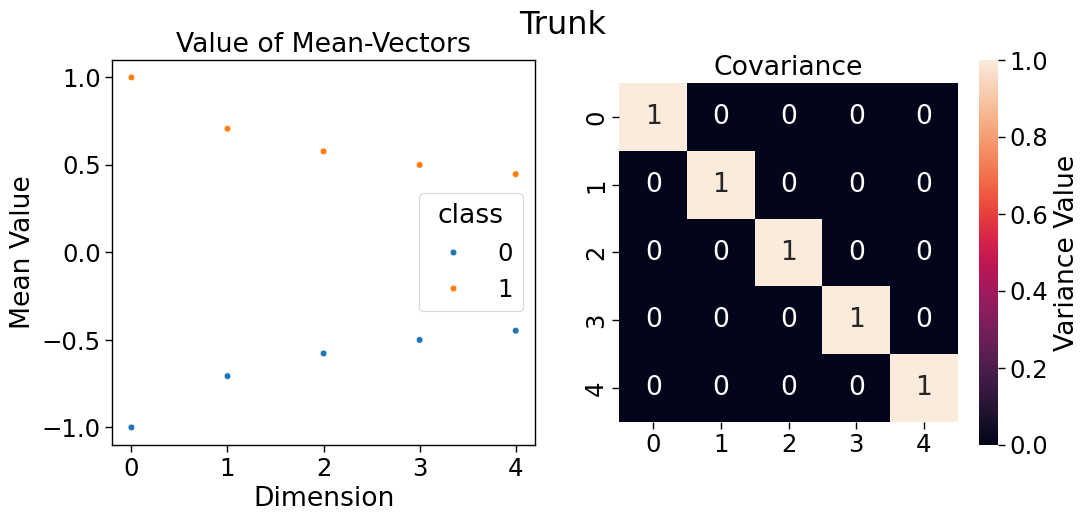

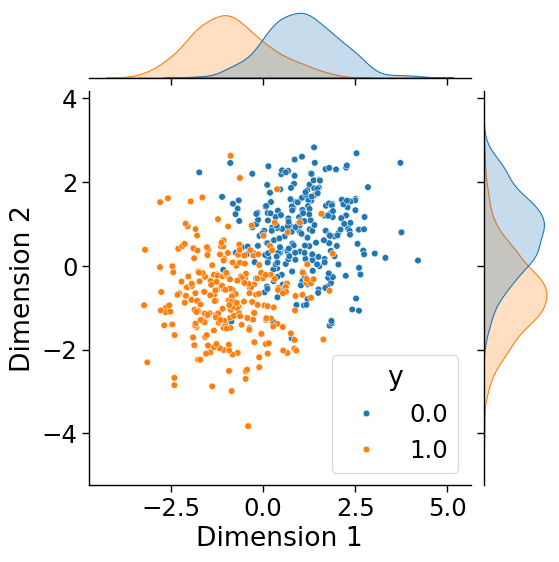

In [22]:
df = pd.DataFrame(means).T
df.reset_index(inplace=True)
df.columns = ["dimension", "0", "1"]
df = pd.melt(df, id_vars=("dimension",), value_name="mean", var_name="class")

sns.set_context("paper", font_scale=2.0)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = sns.scatterplot(x="dimension", y="mean", hue="class", data=df, ax=axs[0])
ax.set(xlabel="Dimension", ylabel="Mean Value", title="Value of Mean-Vectors")

ax = sns.heatmap(
    covs[0], annot=True, square=True, ax=axs[1], cbar_kws={"label": "Variance Value"}
)
ax.set_title("Covariance")
fig.suptitle("Trunk")
plt.show()

# Combine X and y into a DataFrame
data = pd.DataFrame({"Dimension 1": X[:, 0], "Dimension 2": X[:, 1], "y": y.ravel()})

# Create a joint plot with different colors for y == 0 and y == 1
sns.jointplot(data=data, x="Dimension 1", y="Dimension 2", hue="y", kind="scatter")
plt.show()
# # Create a joint plot
# sns.jointplot(x=X[np.argwhere(y == 1).squeeze(), 0], y=X[np.argwhere(y == 1).squeeze(), 1], kind="scatter")
# sns.jointplot(x=X[np.argwhere(y == 0).squeeze(), 0], y=X[np.argwhere(y == 0).squeeze(), 1], kind="scatter")
# # sns.jointplot(x=X[:, 0], y=X[:, 1], kind="scatter")

## Trunk-overlap

In [31]:
X, y, means, covs = make_trunk_classification(
    n_samples=n_samples,
    n_dim=n_dim,
    mu_0=-1,
    mu_1=1,
    simulation="trunk_overlap",
    n_informative=5,
    return_params=True,
)

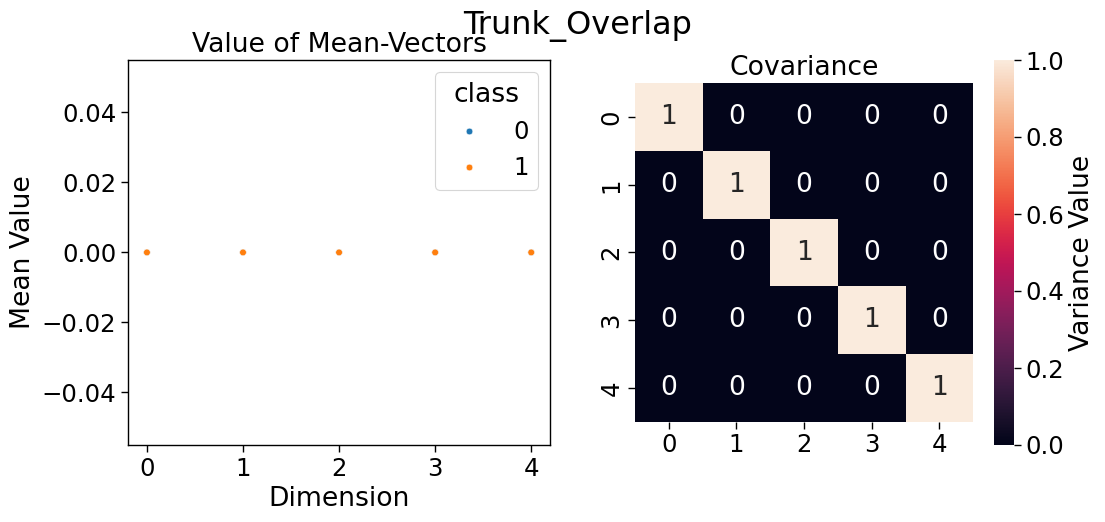

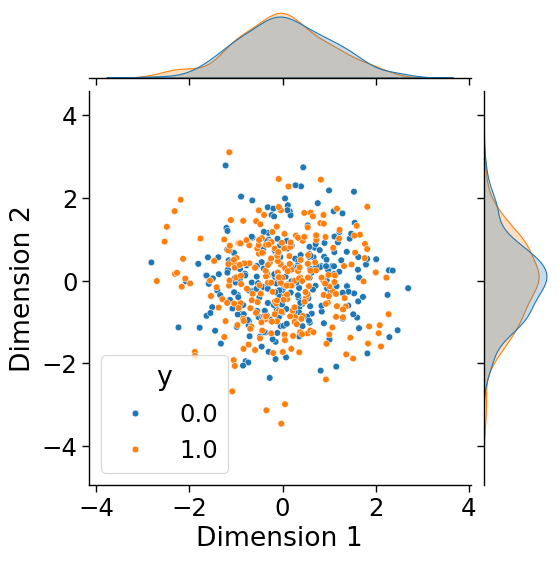

In [33]:
df = pd.DataFrame(means).T
df.reset_index(inplace=True)
df.columns = ["dimension", "0", "1"]
df = pd.melt(df, id_vars=("dimension",), value_name="mean", var_name="class")

sns.set_context("paper", font_scale=2.0)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = sns.scatterplot(x="dimension", y="mean", hue="class", data=df, ax=axs[0])
ax.set(xlabel="Dimension", ylabel="Mean Value", title="Value of Mean-Vectors")

ax = sns.heatmap(
    covs[0], annot=True, square=True, ax=axs[1], cbar_kws={"label": "Variance Value"}
)
ax.set_title("Covariance")
fig.suptitle("Trunk_Overlap")
plt.show()

# Combine X and y into a DataFrame
data = pd.DataFrame({"Dimension 1": X[:, 0], "Dimension 2": X[:, 1], "y": y.ravel()})

# Create a joint plot with different colors for y == 0 and y == 1
sns.jointplot(data=data, x="Dimension 1", y="Dimension 2", hue="y", kind="scatter")
plt.show()

## Trunk-mix

In [34]:
X, y, means, covs, X_mixture = make_trunk_classification(
    n_samples=n_samples,
    n_dim=n_dim,
    mu_0=-1,
    mu_1=1,
    mix=0.25,
    simulation="trunk_mix",
    n_informative=5,
    return_params=True,
)

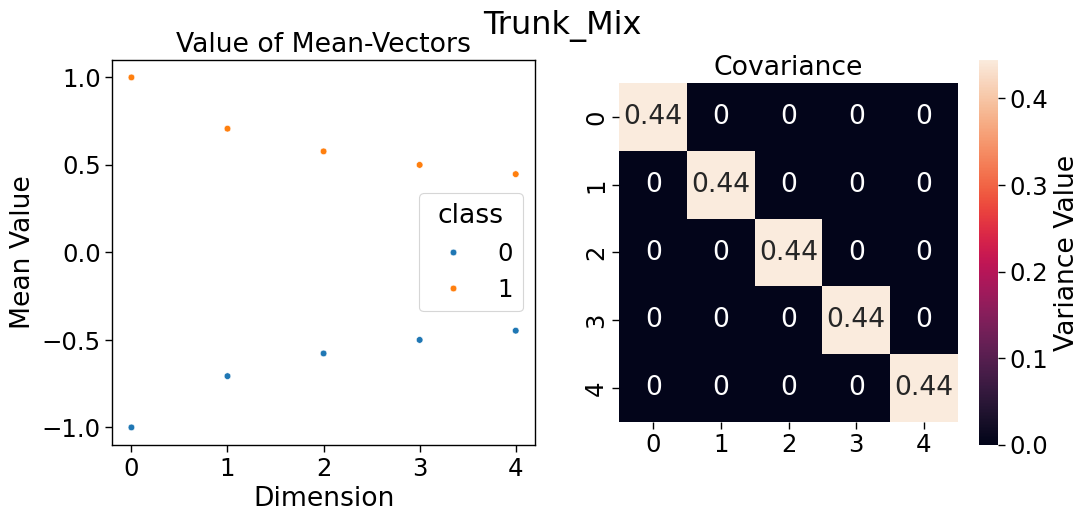

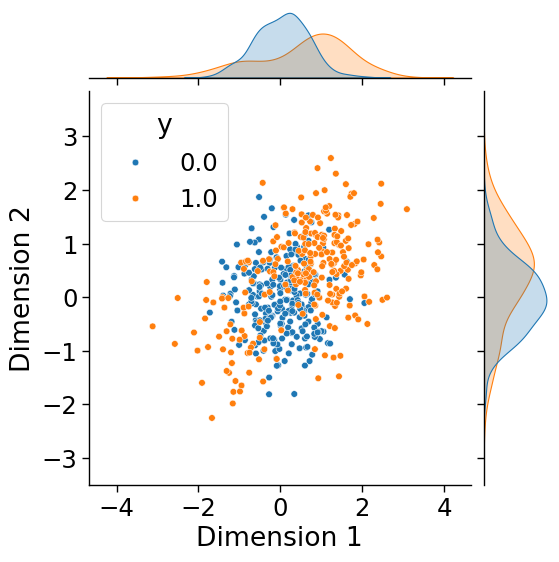

In [35]:
df = pd.DataFrame(means).T
df.reset_index(inplace=True)
df.columns = ["dimension", "0", "1"]
df = pd.melt(df, id_vars=("dimension",), value_name="mean", var_name="class")

sns.set_context("paper", font_scale=2.0)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = sns.scatterplot(x="dimension", y="mean", hue="class", data=df, ax=axs[0])
ax.set(xlabel="Dimension", ylabel="Mean Value", title="Value of Mean-Vectors")

ax = sns.heatmap(
    covs[0], annot=True, square=True, ax=axs[1], cbar_kws={"label": "Variance Value"}
)
ax.set_title("Covariance")
fig.suptitle("Trunk_Mix")
plt.show()

# Combine X and y into a DataFrame
data = pd.DataFrame({"Dimension 1": X[:, 0], "Dimension 2": X[:, 1], "y": y.ravel()})

# Create a joint plot with different colors for y == 0 and y == 1
sns.jointplot(data=data, x="Dimension 1", y="Dimension 2", hue="y", kind="scatter")
plt.show()

# Mean-Shift (Simulation 1)

In [42]:
def make_mean_shift(
    n_samples=1024,
    n_dim_1=4090,
    mu_0=-1,
    mu_1=1,
    seed=None,
    n_dim_2=6,
    return_params=False,
):
    """Make mean shifted binary classification data.

    X comprises of [view_1, view_2] where view_1 is the first ``n_dim_1`` dimensions
    and view_2 is the last ``n_dim_2`` dimensions.

    view_1 is generated, such that [A, B] corresponding to class labels [0, 1]
    are generated as follows:

    A ~ N(1, I)
    B ~ N(m_factor, I)

    view_2 is generated, such that [A, B] corresponding to class labels [0, 1]
    are generated as follows:

    A ~ N(1 / np.sqrt(2), I)
    B ~ N(1 / np.sqrt(2) * m_factor, I)

    Parameters
    ----------
    n_samples : int, optional
        The number of samples to generate, by default 1024.
    n_dim_1 : int, optional
        The number of dimensions in first view, by default 4090.
    mu_0 : int, optional
        The mean of the first class, by default -1.
    mu_1 : int, optional
        The mean of the second class, by default 1.
    seed : int, optional
        Random seed, by default None.
    n_dim_2 : int, optional
        The number of dimensions in second view, by default 6.
    return_params : bool
        Whether to return parameters of the generating model or not. Default is False.

    Returns
    -------
    X : ArrayLike of shape (n_samples, n_dim_1 + n_dim_2)
        Data.
    y : ArrayLike of shape (n_samples,)
        Labels.
    """
    rng = np.random.default_rng(seed)
    default_n_informative = 2

    X, y, means, cov = make_trunk_classification(
        n_samples=n_samples,
        n_dim=n_dim_1 + default_n_informative,
        n_informative=default_n_informative,
        mu_0=mu_0,
        mu_1=mu_1,
        return_params=True,
        seed=seed,
    )
    # get the second informative dimension
    view_1 = X[:, 1:]

    # only take one informative dimension
    view_2 = X[:, (0,)]

    # add noise to the second view so that view_2 = (n_samples, n_dim_2)
    view_2 = np.concatenate(
        (view_2, rng.standard_normal(size=(n_samples, n_dim_2 - view_2.shape[1]))),
        axis=1,
    )

    X = np.concatenate((view_1, view_2), axis=1)
    if return_params:
        return X, y, means, covs
    return X, y

In [44]:
X, y, means, covs = make_mean_shift(
    n_samples=1024,
    n_dim_1=4090,
    mu_0=-1,
    mu_1=1,
    seed=1,
    n_dim_2=6,
    return_params=True,
)

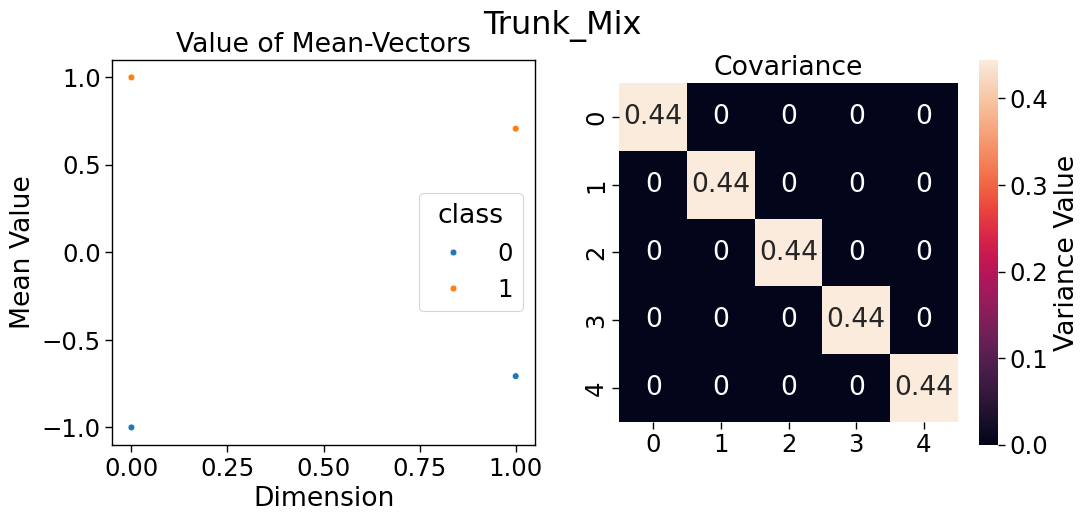

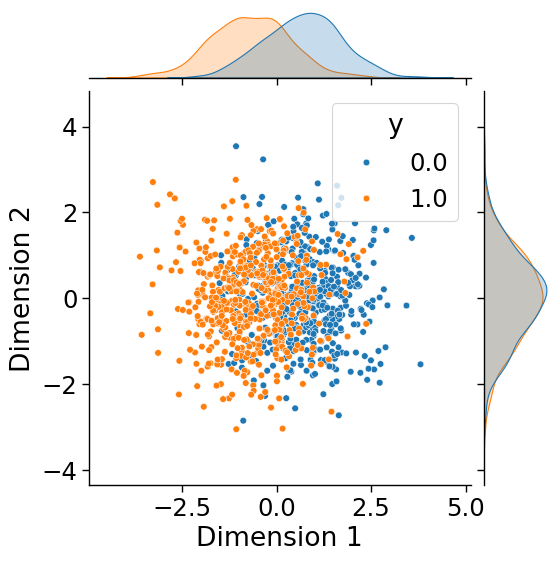

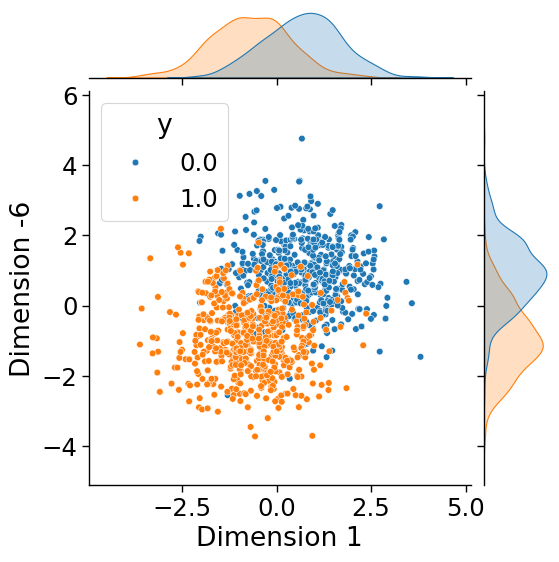

In [48]:
df = pd.DataFrame(means).T
df.reset_index(inplace=True)
df.columns = ["dimension", "0", "1"]
df = pd.melt(df, id_vars=("dimension",), value_name="mean", var_name="class")

sns.set_context("paper", font_scale=2.0)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = sns.scatterplot(x="dimension", y="mean", hue="class", data=df, ax=axs[0])
ax.set(xlabel="Dimension", ylabel="Mean Value", title="Value of Mean-Vectors")

ax = sns.heatmap(
    covs[0], annot=True, square=True, ax=axs[1], cbar_kws={"label": "Variance Value"}
)
ax.set_title("Covariance")
fig.suptitle("Trunk_Mix")
plt.show()

# Combine X and y into a DataFrame
data = pd.DataFrame({"Dimension 1": X[:, 0], "Dimension 2": X[:, 1], "y": y.ravel()})
# Create a joint plot with different colors for y == 0 and y == 1
sns.jointplot(data=data, x="Dimension 1", y="Dimension 2", hue="y", kind="scatter")

data = pd.DataFrame({"Dimension 1": X[:, 0], "Dimension -6": X[:, -6], "y": y.ravel()})

# Create a joint plot with different colors for y == 0 and y == 1
sns.jointplot(data=data, x="Dimension 1", y="Dimension -6", hue="y", kind="scatter")
plt.show()

# Multi-modal

In [54]:
def make_multi_modal(
    n_samples=1024,
    n_dim_1=4090,
    mu_0=1,
    mu_1=-1,
    mix=0.5,
    seed=None,
    n_dim_2=6,
    return_params=False,
):
    """Make multi-modal binary classification data.

    X comprises of [view_1, view_2] where view_1 is the first ``n_dim_1`` dimensions
    and view_2 is the last ``n_dim_2`` dimensions.

    view_1 is generated, such that [A, B] corresponding to class labels [0, 1]
    are generated as follows:

    A ~ N(0, I)
    B ~ mix * N(1, I) + (1 - mix) * N(m_factor, I)

    view_2 is generated, such that [A, B] corresponding to class labels [0, 1]
    are generated as follows:

    A ~ N(0, I)
    B ~ mix * N(1 / np.sqrt(2), I) + (1 - mix) * N(1 / np.sqrt(2) * m_factor, I)

    Parameters
    ----------
    n_samples : int, optional
        The number of samples to generate, by default 1024.
    n_dim_1 : int, optional
        The number of dimensions in first view, by default 4090.
    mu_0 : int, optional
        The mean of the first class, by default 1.
    mu_1 : int, optional
        The mean of the second class, by default -1.
    seed : int, optional
        Random seed, by default None.
    n_dim_2 : int, optional
        The number of dimensions in second view, by default 6.
    return_params : bool
        Whether to return parameters of the generating model or not. Default is False.

    Returns
    -------
    X : ArrayLike of shape (n_samples, n_dim_1 + n_dim_2)
        Data.
    y : ArrayLike of shape (n_samples,)
        Labels.
    """
    rng = np.random.default_rng(seed)
    default_n_informative = 2

    X, y, means, covs, X_mixture = make_trunk_classification(
        n_samples=n_samples,
        n_dim=n_dim_1 + default_n_informative,
        n_informative=default_n_informative,
        mu_0=mu_0,
        mu_1=mu_1,
        simulation="trunk_mix",
        mix=mix,
        seed=seed,
        return_params=True,
    )
    # get the second informative dimension
    view_1 = X[:, 1:]

    # only take one informative dimension
    view_2 = X[:, (0,)]

    # add noise to the second view so that view_2 = (n_samples, n_dim_2)
    view_2 = np.concatenate(
        (view_2, rng.standard_normal(size=(n_samples, n_dim_2 - view_2.shape[1]))),
        axis=1,
    )
    X = np.concatenate((view_1, view_2), axis=1)
    if return_params:
        return X, y, means, covs, X_mixture
    return X, y

In [55]:
X, y, means, covs, X_mixture = make_multi_modal(
    n_samples=1024,
    n_dim_1=4090,
    mu_0=-1,
    mu_1=1,
    seed=1,
    n_dim_2=6,
    return_params=True,
)

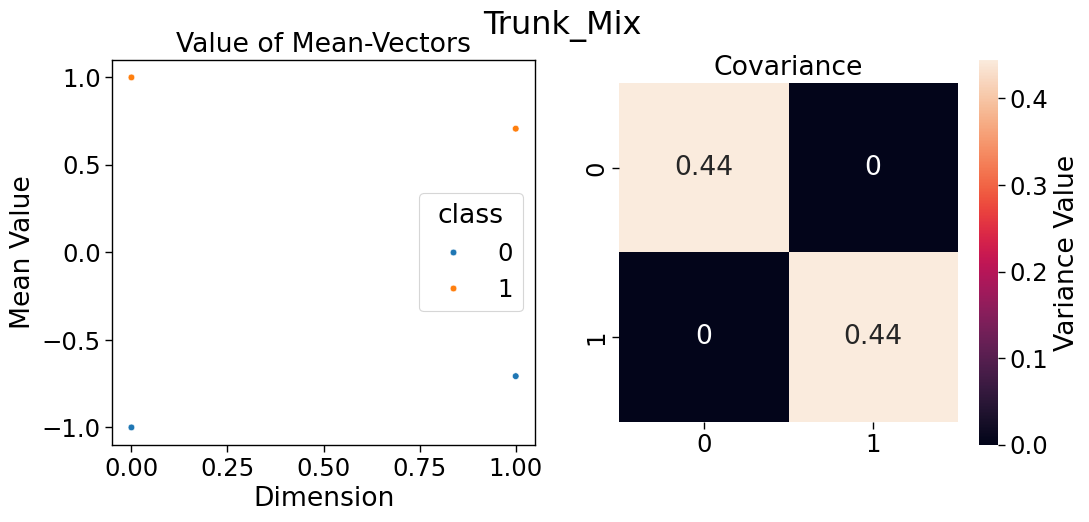

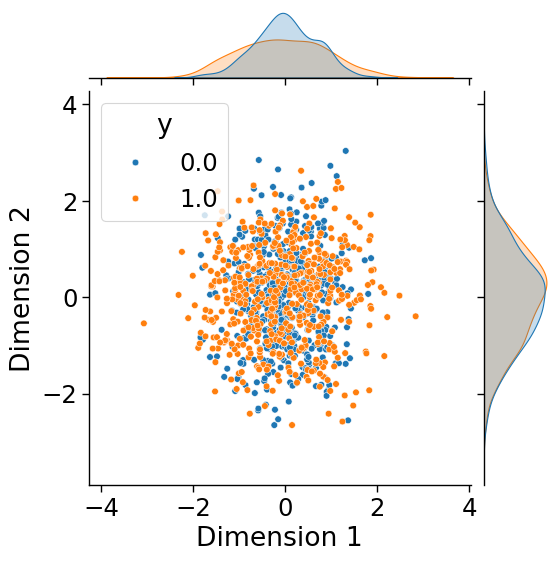

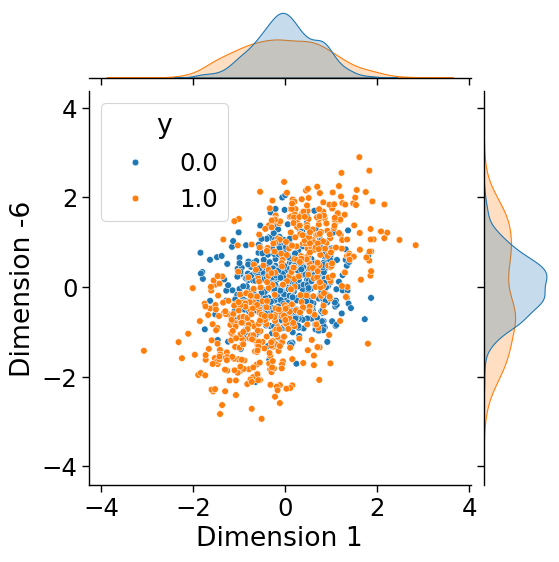

In [56]:
df = pd.DataFrame(means).T
df.reset_index(inplace=True)
df.columns = ["dimension", "0", "1"]
df = pd.melt(df, id_vars=("dimension",), value_name="mean", var_name="class")

sns.set_context("paper", font_scale=2.0)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = sns.scatterplot(x="dimension", y="mean", hue="class", data=df, ax=axs[0])
ax.set(xlabel="Dimension", ylabel="Mean Value", title="Value of Mean-Vectors")

ax = sns.heatmap(
    covs[0], annot=True, square=True, ax=axs[1], cbar_kws={"label": "Variance Value"}
)
ax.set_title("Covariance")
fig.suptitle("Trunk_Mix")
plt.show()

# Combine X and y into a DataFrame
data = pd.DataFrame({"Dimension 1": X[:, 0], "Dimension 2": X[:, 1], "y": y.ravel()})
# Create a joint plot with different colors for y == 0 and y == 1
sns.jointplot(data=data, x="Dimension 1", y="Dimension 2", hue="y", kind="scatter")

data = pd.DataFrame({"Dimension 1": X[:, 0], "Dimension -6": X[:, -6], "y": y.ravel()})

# Create a joint plot with different colors for y == 0 and y == 1
sns.jointplot(data=data, x="Dimension 1", y="Dimension -6", hue="y", kind="scatter")
plt.show()

# Multi-equal

In [65]:
def make_multi_equal(
    n_samples=1024,
    n_dim_1=4090,
    mu_0=1,
    mu_1=-1,
    mix=0.5,
    seed=None,
    n_dim_2=6,
    return_params=False,
):
    """Make multi-modal binary classification data.

    X comprises of [view_1, view_2] where view_1 is the first ``n_dim_1`` dimensions
    and view_2 is the last ``n_dim_2`` dimensions.

    view_1 is generated, such that [A, B] corresponding to class labels [0, 1]
    are generated as follows:

    A ~ mix * N(1, I) + (1 - mix) * N(m_factor, I)
    B ~ mix * N(1, I) + (1 - mix) * N(m_factor, I)

    view_2 is generated, such that [A, B] corresponding to class labels [0, 1]
    are generated as follows:

    A ~ mix * N(1 / np.sqrt(2), I) + (1 - mix) * N(1 / np.sqrt(2) * m_factor, I)
    B ~ mix * N(1 / np.sqrt(2), I) + (1 - mix) * N(1 / np.sqrt(2) * m_factor, I)

    Parameters
    ----------
    n_samples : int, optional
        The number of samples to generate, by default 1024.
    n_dim_1 : int, optional
        The number of dimensions in first view, by default 4090.
    mu_0 : int, optional
        The mean of the first class, by default 1.
    mu_1 : int, optional
        The mean of the second class, by default -1.
    seed : int, optional
        Random seed, by default None.
    n_dim_2 : int, optional
        The number of dimensions in second view, by default 6.
    return_params : bool
        Whether to return parameters of the generating model or not. Default is False.

    Returns
    -------
    X : ArrayLike of shape (n_samples, n_dim_1 + n_dim_2)
        Data.
    y : ArrayLike of shape (n_samples,)
        Labels.
    """
    rng = np.random.default_rng(seed)
    default_n_informative = 2

    X1, _ = make_trunk_classification(
        n_samples=n_samples,
        n_dim=n_dim_1 + default_n_informative,
        n_informative=default_n_informative,
        mu_0=mu_0,
        mu_1=mu_1,
        simulation="trunk_mix",
        mix=mix,
        seed=rng.integers(0, np.iinfo(np.int32).max),
        return_params=False,
    )
    # only keep the second half of samples, corresponding to the mixture
    X1 = X1[n_samples // 2 :, :]

    X2, _ = make_trunk_classification(
        n_samples=n_samples,
        n_dim=n_dim_1 + default_n_informative,
        n_informative=default_n_informative,
        mu_0=mu_0,
        mu_1=mu_1,
        simulation="trunk_mix",
        mix=mix,
        seed=rng.integers(0, np.iinfo(np.int32).max),
        return_params=False,
    )
    # only keep the second half of samples, corresponding to the mixture
    X2 = X2[n_samples // 2 :, :]

    X = np.vstack((X1, X2))
    y = np.hstack((np.zeros(n_samples // 2), np.ones(n_samples // 2)))

    # get the second informative dimension
    view_1 = X[:, 1:]

    # only take one informative dimension
    view_2 = X[:, (0,)]

    # add noise to the second view so that view_2 = (n_samples, n_dim_2)
    view_2 = np.concatenate(
        (view_2, rng.standard_normal(size=(n_samples, n_dim_2 - view_2.shape[1]))),
        axis=1,
    )
    X = np.concatenate((view_1, view_2), axis=1)
    return X, y

In [66]:
X, y = make_multi_equal(
    n_samples=1024,
    n_dim_1=4090,
    mu_0=-1,
    mu_1=1,
    seed=1,
    n_dim_2=6,
    return_params=False,
)

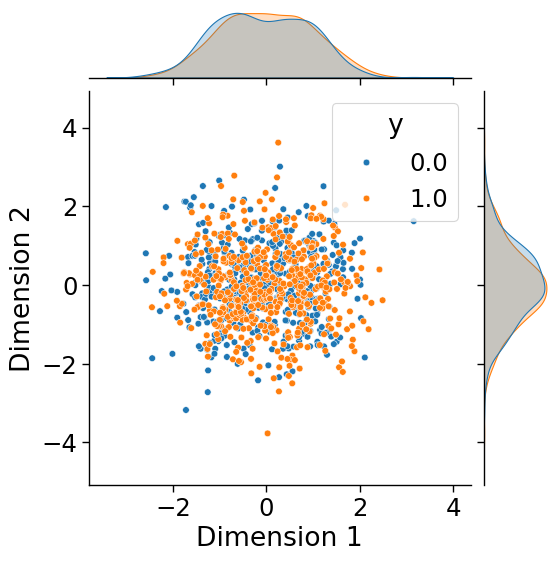

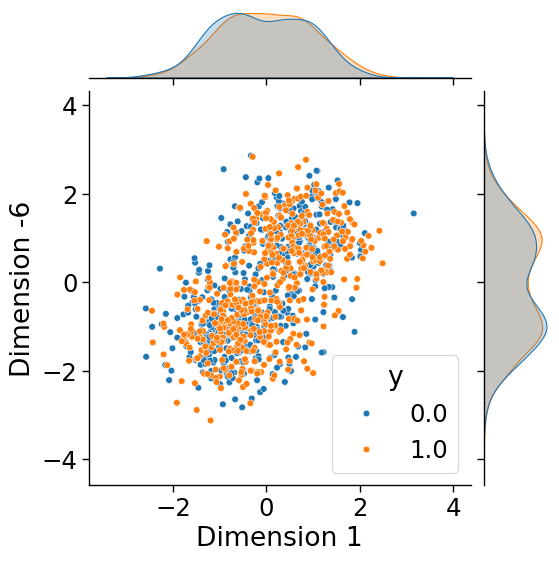

In [67]:
# Combine X and y into a DataFrame
data = pd.DataFrame({"Dimension 1": X[:, 0], "Dimension 2": X[:, 1], "y": y.ravel()})
# Create a joint plot with different colors for y == 0 and y == 1
sns.jointplot(data=data, x="Dimension 1", y="Dimension 2", hue="y", kind="scatter")

data = pd.DataFrame({"Dimension 1": X[:, 0], "Dimension -6": X[:, -6], "y": y.ravel()})

# Create a joint plot with different colors for y == 0 and y == 1
sns.jointplot(data=data, x="Dimension 1", y="Dimension -6", hue="y", kind="scatter")
plt.show()